### **Precipitation Data**
#### Read the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.ticker import MaxNLocator

In [2]:
file_path = './data/234dailys.xls'

# read the data
rf = pd.read_excel(file_path,skiprows=9)
rf.rename(columns=rf.iloc[0]).drop(rf.index[0]).reset_index(drop=True)
rf['datetime'] = pd.to_datetime(rf[['year', 'month', 'day']])

# Turn daily rain's unit from inches to millimeters
rf['daily rain'] *= 25.4

rf

,station id,water year,year,month,day,daily rain,code,datetime
0,234,1900,1899,10,11,3.048,E339,1899-10-11
1,234,1900,1899,10,12,2.032,E339,1899-10-12
2,234,1900,1899,10,13,33.020,E339,1899-10-13
3,234,1900,1899,10,14,0.508,E339,1899-10-14
4,234,1900,1899,10,21,11.684,E339,1899-10-21
...,...,...,...,...,...,...,...,...
4646,234,2023,2023,6,12,0.254,NaN,2023-06-12
4647,234,2023,2023,8,10,6.096,NaN,2023-08-10
4648,234,2023,2023,8,11,1.524,NaN,2023-08-11
4649,234,2023,2023,8,21,7.366,NaN,2023-08-21


In [3]:
# Year range
print('data recorded from:', int(rf.describe().year.iloc[3]), 'to:',int(rf.describe().year.iloc[7]))

data recorded from: 1899 to: 2023


#### Add attributes to dataframe


In [4]:
rf.attrs['Description'] ='County of Santa Barbara'
rf.attrs['Station id']  = 234
rf.attrs['Latitude']    = '34-25-34'
rf.attrs['Longitude']   = '119-42-13'
rf.attrs['Elevation m'] = '130 ft'

print (rf.attrs)

{'Description': 'County of Santa Barbara', 'Station id': 234, 'Latitude': '34-25-34', 'Longitude': '119-42-13', 'Elevation m': '130 ft'}


#### Group by month and find top 5% precipitation for each month

fill out other empty days

In [5]:
# Group by month and find top 5% for each month, not including the 0's
extremes = rf.loc[(rf['daily rain']!=0)].groupby('month').quantile(0.95)['daily rain']

rf['binary rain'] = rf.apply(lambda row: 1 if row['daily rain'] > extremes[row['month']] else 0, axis=1)
rf

/var/folders/qd/nfpzqtz54rx879c00hvvjfyw0000gn/T/ipykernel_1533/1219177639.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  extremes = rf.loc[(rf['daily rain']!=0)].groupby('month').quantile(0.95)['daily rain']


,station id,water year,year,month,day,daily rain,code,datetime,binary rain
0,234,1900,1899,10,11,3.048,E339,1899-10-11,0
1,234,1900,1899,10,12,2.032,E339,1899-10-12,0
2,234,1900,1899,10,13,33.020,E339,1899-10-13,1
3,234,1900,1899,10,14,0.508,E339,1899-10-14,0
4,234,1900,1899,10,21,11.684,E339,1899-10-21,0
...,...,...,...,...,...,...,...,...,...
4646,234,2023,2023,6,12,0.254,NaN,2023-06-12,0
4647,234,2023,2023,8,10,6.096,NaN,2023-08-10,0
4648,234,2023,2023,8,11,1.524,NaN,2023-08-11,0
4649,234,2023,2023,8,21,7.366,NaN,2023-08-21,1


In [6]:
# Fill the missing date with 0's for binary rain
idx = pd.date_range('1899-10-11', '2023-08-31')
rf = rf.set_index(rf.datetime).reindex(idx, fill_value=0)

In [7]:
# ok to remove water year?
rf['year'] = rf.index.year
rf['month'] = rf.index.month
rf['day'] = rf.index.day
rf

,station id,water year,year,month,day,daily rain,code,datetime,binary rain
1899-10-11,234,1900,1899,10,11,3.048,E339,1899-10-11 00:00:00,0
1899-10-12,234,1900,1899,10,12,2.032,E339,1899-10-12 00:00:00,0
1899-10-13,234,1900,1899,10,13,33.020,E339,1899-10-13 00:00:00,1
1899-10-14,234,1900,1899,10,14,0.508,E339,1899-10-14 00:00:00,0
1899-10-15,0,0,1899,10,15,0.000,0,0,0
...,...,...,...,...,...,...,...,...,...
2023-08-27,0,0,2023,8,27,0.000,0,0,0
2023-08-28,0,0,2023,8,28,0.000,0,0,0
2023-08-29,0,0,2023,8,29,0.000,0,0,0
2023-08-30,0,0,2023,8,30,0.000,0,0,0


In [8]:
# Checking
rf[(rf['month'] == 1) & (rf['daily rain'] > extremes[1])].count()['binary rain'] == rf[(rf['month'] == 1) & (rf['binary rain'] == 1)].count()['binary rain']

True

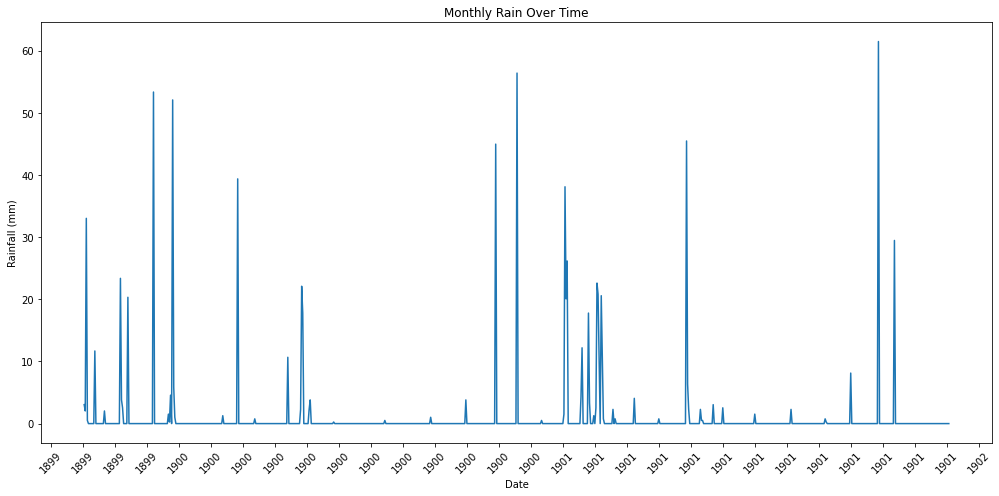

In [9]:
new = rf.loc['1899-10-11':'1901-12-31']
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=30))

plt.plot(new.index,new['daily rain'],label = 'Monthly Rain')
plt.title('Monthly Rain Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

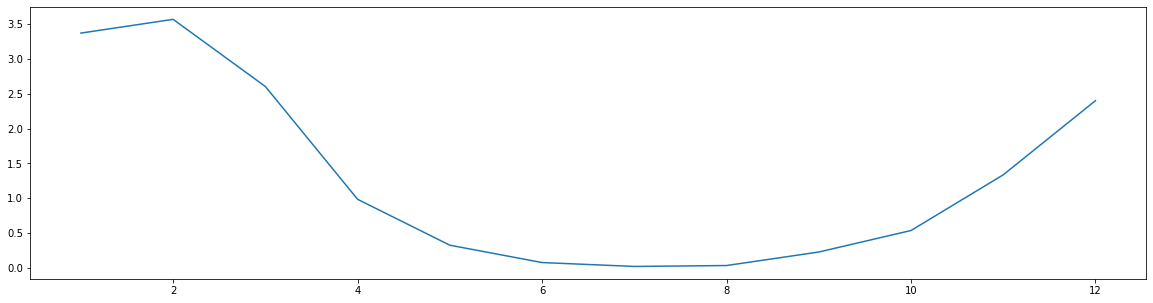

In [10]:
# Climatology
avg_month = rf.groupby('month').mean()['daily rain']
avg_month

plt.figure(figsize=(20, 5))
plt.plot(avg_month)

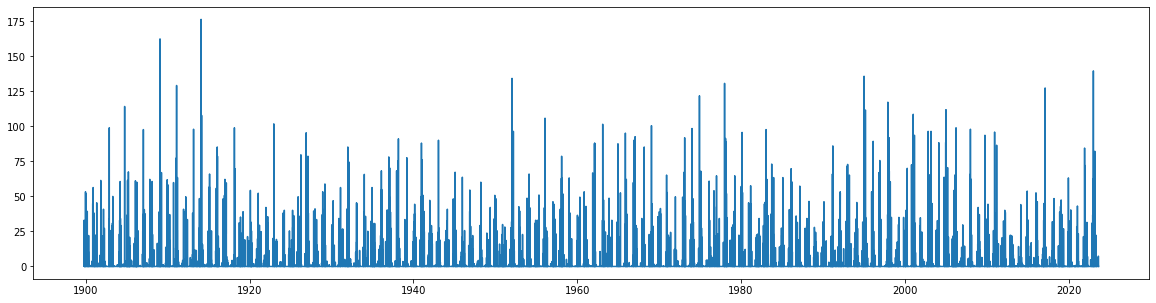

In [11]:
plt.figure(figsize=(20, 5))
plt.plot(rf['daily rain'])

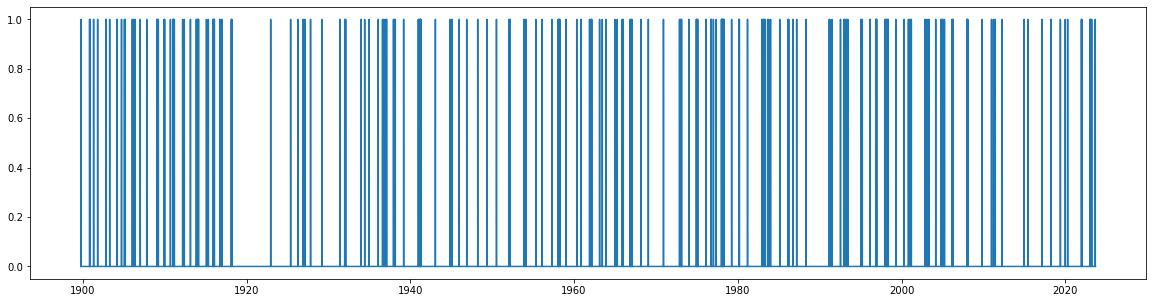

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(rf['binary rain'])

In [13]:
rf.to_csv("/Users/pippalin/Extreme-Precipitation/data/precipitation_clean")

### **SOI Data**
#### Read the data

In [14]:
file_path = './data/SOI.darwin.annstd.txt'

# read the data
soi = pd.read_csv(file_path, delim_whitespace= True, names=['year',1,2,3,4,5,6,7,8,9,10,11,12],header = None)

#### Check missing value

In [15]:
# Check null values
# Find rows with -99.9 values and count them per year
neg_99 = (soi == -99.9).sum().sum()

# Find rows with NaN values and count them per year
nan_counts = soi.isnull().sum().sum()

#print(neg_99,nan_counts)
print(f'Total count of -99.9 values: {neg_99}')
print(f'Total count of NaN values: {nan_counts}')

Total count of -99.9 values: 9
Total count of NaN values: 0


#### Interpolate the missing values

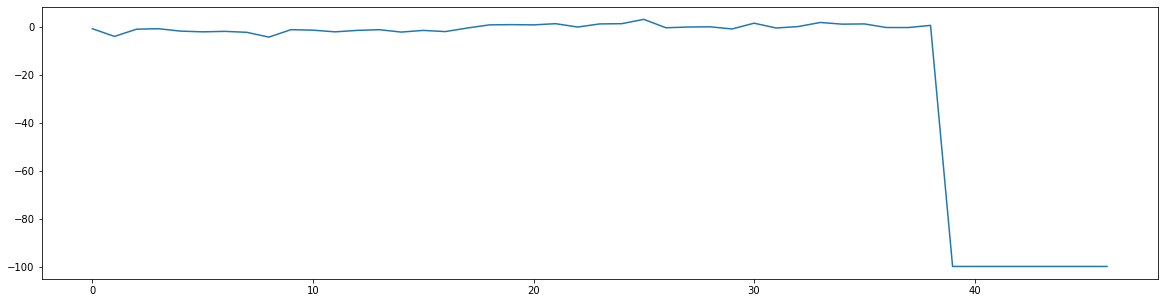

In [16]:
# Check pattern
plt_soi = soi
plt_soival = plt_soi.drop('year', axis=1) # Drop for plot
# Flatten the DataFrame values into a list
flattened_list = plt_soival.values.flatten().tolist()
plt.figure(figsize=(20, 5))
plt.plot(flattened_list[-48:-1])

Based on this plot, we decided to use spline interpolation

In [17]:
# Replace -99.9 with np.nan for interpolation purposes
soi = soi.replace(-99.9, np.nan)

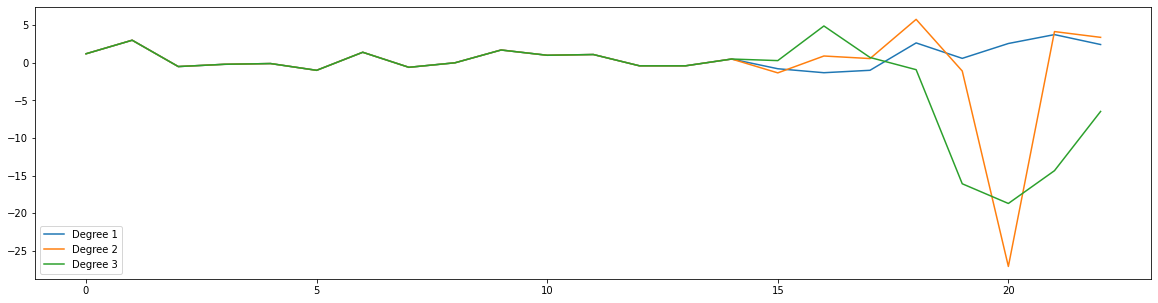

In [18]:
plt.figure(figsize=(20, 5))

# Compare 3 degree of spline:
# Interpolate using a spline of order 3 (cubic spline)
soi_interpolated_1 = soi.apply(lambda series: series.interpolate(method='spline', order=1))
soi_interpolated_2 = soi.apply(lambda series: series.interpolate(method='spline', order=2))
soi_interpolated_3 = soi.apply(lambda series: series.interpolate(method='spline', order=3))

# Check pattern
plt_soi_1 = soi_interpolated_1
plt_soi_2 = soi_interpolated_2
plt_soi_3 = soi_interpolated_3

plt_soival_1 = plt_soi_1.drop('year', axis=1) # Drop for plot
plt_soival_2 = plt_soi_2.drop('year', axis=1) 
plt_soival_3 = plt_soi_3.drop('year', axis=1) 

# Flatten the DataFrame values into a list
flattened_list_1 = plt_soival_1.values.flatten().tolist()
flattened_list_2 = plt_soival_2.values.flatten().tolist()
flattened_list_3 = plt_soival_3.values.flatten().tolist()

# Plot
plt.plot(flattened_list_1[-24:-1], label='Degree 1')
plt.plot(flattened_list_2[-24:-1], label='Degree 2')
plt.plot(flattened_list_3[-24:-1],label='Degree 3')
plt.legend()
plt.show()

Thus, we choose degree 1:

In [19]:
soi_interpolated = soi_interpolated_1.round(1)
soi_interpolated

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,1866,-1.6,0.7,-0.9,-0.2,0.9,-1.0,-0.0,-0.1,0.4,0.1,0.3,-1.2
1,1867,-2.0,0.5,-1.6,-0.2,0.9,0.3,0.5,1.0,1.3,1.9,-2.9,-1.3
2,1868,0.5,-0.4,-1.1,-1.0,-2.1,-2.0,-0.6,-1.0,-0.9,-1.1,-2.9,-1.0
3,1869,-2.5,-1.3,-3.4,5.0,3.4,2.7,1.0,2.9,0.9,2.7,1.9,1.8
4,1870,4.2,2.6,-1.9,-0.7,-1.0,-1.3,0.7,2.4,0.5,-0.6,-0.9,-3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2018,2.6,-0.6,3.0,0.2,-1.7,-2.0,0.5,-0.3,-0.5,-0.6,-0.9,1.7
153,2019,-0.9,-4.1,-1.1,-0.9,-1.9,-2.2,-2.0,-2.4,-4.4,-1.3,-1.5,-2.2
154,2020,-1.6,-1.3,-2.3,-1.6,-2.1,-0.6,0.7,0.8,0.7,1.2,-0.2,1.1
155,2021,1.2,3.0,-0.5,-0.2,-0.1,-1.0,1.4,-0.6,0.0,1.7,1.0,1.1


#### Transform the data: 
* soi > 0 to 1
* soi < 0 to -1
* soi = 0 to 0

In [20]:
# Turn to -1, 0, 1
def transform(x):
    if x < 0:
        return -1
    elif x > 0:
        return 1
    else:
        return 0
    
soi_interpolated.iloc[:,1:13] = soi_interpolated.iloc[:,1:13].applymap(transform)
soi_interpolated

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,1866,-1,1,-1,-1,1,-1,0,-1,1,1,1,-1
1,1867,-1,1,-1,-1,1,1,1,1,1,1,-1,-1
2,1868,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1869,-1,-1,-1,1,1,1,1,1,1,1,1,1
4,1870,1,1,-1,-1,-1,-1,1,1,1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2018,1,-1,1,1,-1,-1,1,-1,-1,-1,-1,1
153,2019,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
154,2020,-1,-1,-1,-1,-1,-1,1,1,1,1,-1,1
155,2021,1,1,-1,-1,-1,-1,1,-1,0,1,1,1


In [21]:
# Melt the dataset
soi_interpolated = soi_interpolated.reset_index(drop=True)
melted_soi = pd.melt(soi_interpolated, id_vars=['year'], var_name='month', value_name='soi').sort_values(by=['year', 'month'])
melted_soi

,year,month,soi
0,1866,1,-1
157,1866,2,1
314,1866,3,-1
471,1866,4,-1
628,1866,5,1
...,...,...,...
1255,2022,8,1
1412,2022,9,1
1569,2022,10,1
1726,2022,11,1


### **Merge Data**

In [22]:
# Merge two datasets
df = pd.merge(rf, melted_soi, left_on=['year', 'month'], right_on=['year', 'month'], how='inner')

### Remove unwanted column

In [23]:
df = df.drop(["station id","water year","code","datetime"], axis = 1)
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Set the 'date' column as the index of the DataFrame
df.set_index('date', inplace=True)

In [24]:
df

,year,month,day,daily rain,binary rain,soi
date,,,,,,
1899-10-11,1899,10,11,3.048000,0,-1
1899-10-12,1899,10,12,2.032000,0,-1
1899-10-13,1899,10,13,33.020000,1,-1
1899-10-14,1899,10,14,0.508000,0,-1
1899-10-15,1899,10,15,0.000000,0,-1
...,...,...,...,...,...,...
2022-12-27,2022,12,27,0.000000,0,1
2022-12-28,2022,12,28,22.859999,0,1
2022-12-29,2022,12,29,0.000000,0,1


In [25]:
df.to_csv("/Users/pippalin/Extreme-Precipitation/data/precipitation_soi")

### Proportion of Extreme

In [26]:
pos_prop = df['binary rain'].sum()/ len(df['binary rain'])
num_days = len(df['binary rain'])
print(f'Number of Days: {num_days}')
print(f'Proportion of extreme precpiptation: {pos_prop}')

Number of Days: 45007
Proportion of extreme precpiptation: 0.0050436598751305356


### Monthly Data

In [37]:
monthly_rain = df['daily rain'].resample('M').sum()
monthly_binary_rain = df['binary rain'].resample('M').max()
day = df['day'].resample('M').max()

# Combine the results into a new DataFrame.
monthly_df = pd.DataFrame({
    'year': monthly_rain.index.year,
    'month': monthly_rain.index.month,
    'day': day,
    'monthly rain': monthly_rain,
    'binary rain': monthly_binary_rain
})

monthly_df['date'] = pd.to_datetime(monthly_df[['year', 'month','day']]).dt.strftime('%Y-%m')
monthly_df = pd.merge(monthly_df, melted_soi, left_on=['year', 'month'], right_on=['year', 'month'], how='inner')
monthly_df = monthly_df.set_index('date')

In [38]:
monthly_df

,year,month,day,monthly rain,binary rain,soi
date,,,,,,
1899-10,1899,10,31,52.324000,1,-1
1899-11,1899,11,30,50.038000,0,-1
1899-12,1899,12,31,59.690000,0,-1
1900-01,1900,1,31,58.928000,0,-1
1900-02,1900,2,28,1.270000,0,-1
...,...,...,...,...,...,...
2022-08,2022,8,31,0.000000,0,1
2022-09,2022,9,30,5.080000,0,1
2022-10,2022,10,31,1.270000,0,1


In [40]:
monthly_df.loc['1900-12']

year             1900
month              12
day                31
monthly rain    0.508
binary rain         0
soi                -1
Name: 1900-12, dtype: object

In [29]:
m_pos_prop = monthly_df['binary rain'].sum()/ len(monthly_df['binary rain'])
m_num_days = len(monthly_df['binary rain'])
print(f'Number of Days: {m_num_days}')
print(f'Proportion of extreme precpiptation: {m_pos_prop}')

Number of Days: 1479
Proportion of extreme precpiptation: 0.12102772143340094


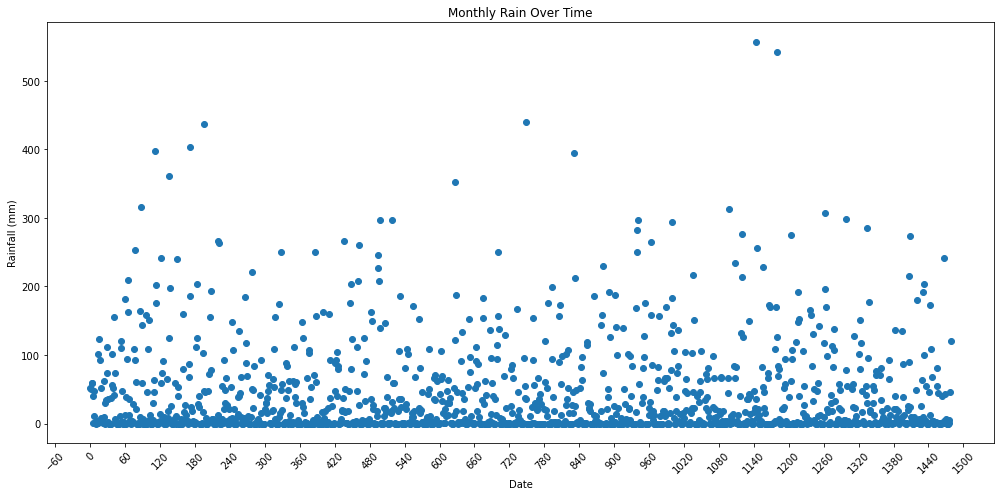

In [30]:
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=30))

plt.plot(monthly_df.index,monthly_df['monthly rain'],'o',label = 'Monthly Rain')
plt.title('Monthly Rain Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

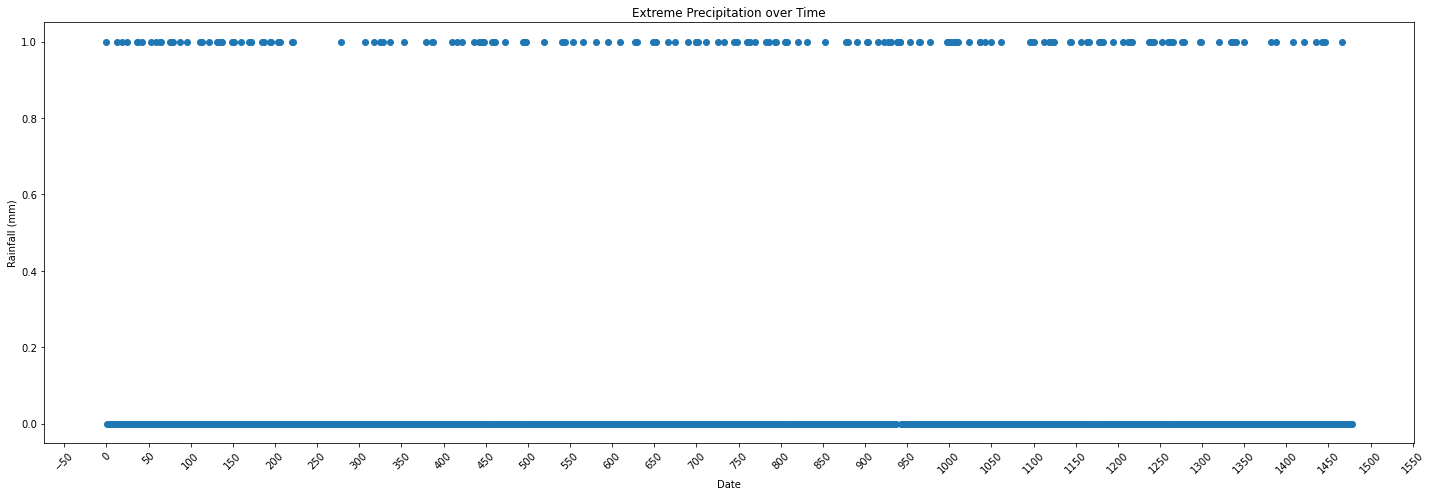

In [31]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(monthly_df.index, monthly_df['binary rain'], 'o', label = 'Extreme Precipitation')
plt.title('Extreme Precipitation over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

In [32]:
monthly_df.to_csv("/Users/pippalin/Extreme-Precipitation/data/precipitation_soi_monthly")